# Оптимизация маркетинговых затрат в Яндекс.Афише

### Задача

На основе данных о посещениях сайта Яндекс.Афиши изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается.

### Содержание исследования

1. Знакомство с данными.
2. Расчет метрик:
    * Исследование данных о посещениях сайта: среднее количество пользователей по времени и источникам, расчет Retention Rate.
    * Исследование данных о продажах, расчет среднего чека и LTV.
    * Исследование данных о затратах: средние затраты на привлечение пользователей, расчет окупаемости (ROI), анализ затрат на привлечение по источникам.
3. Общий вывод по исследованию.

### 1. Загрузка и предобработка данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import numpy as np

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
visits = pd.read_csv('/datasets/visits.csv')
visits.head()

,Unnamed: 0,Device,End Ts,Source Id,Start Ts,Uid
0,0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  359400 non-null  int64 
 1   Device      359400 non-null  object
 2   End Ts      359400 non-null  object
 3   Source Id   359400 non-null  int64 
 4   Start Ts    359400 non-null  object
 5   Uid         359400 non-null  uint64
dtypes: int64(2), object(3), uint64(1)
memory usage: 16.5+ MB


In [4]:
orders = pd.read_csv('/datasets/orders.csv')
orders.head()

,Unnamed: 0,Buy Ts,Revenue,Uid
0,0,2017-06-01 00:10:00,17.00,10329302124590727494
1,1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2,2017-06-01 00:27:00,0.37,17903680561304213844
3,3,2017-06-01 00:29:00,0.55,16109239769442553005
4,4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50415 non-null  int64  
 1   Buy Ts      50415 non-null  object 
 2   Revenue     50415 non-null  float64
 3   Uid         50415 non-null  uint64 
dtypes: float64(1), int64(1), object(1), uint64(1)
memory usage: 1.5+ MB


In [6]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,Unnamed: 0,source_id,dt,costs
0,0,1,2017-06-01,75.20
1,1,1,2017-06-02,62.25
2,2,1,2017-06-03,36.53
3,3,1,2017-06-04,55.00
4,4,1,2017-06-05,57.08


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2542 non-null   int64  
 1   source_id   2542 non-null   int64  
 2   dt          2542 non-null   object 
 3   costs       2542 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 79.6+ KB


In [8]:
#изменим написание названия колонок
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
visits.columns = visits.columns.str.replace(' ','_')
orders.columns = orders.columns.str.replace(' ','_')

In [9]:
#приведение к формату datetime всех колонок, содержащих даты
def to_date(data, column):
    data[column] = pd.to_datetime(data[column])

to_date(visits, 'end_ts')
to_date(visits, 'start_ts')
to_date(orders, 'buy_ts')
to_date(costs, 'dt')

In [10]:
#отбрасываем строки, где время начала сессии позже времени окончания сессии
visits = visits[visits['start_ts'] <= visits['end_ts']]
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359398 entries, 0 to 359399
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   unnamed:_0  359398 non-null  int64         
 1   device      359398 non-null  object        
 2   end_ts      359398 non-null  datetime64[ns]
 3   source_id   359398 non-null  int64         
 4   start_ts    359398 non-null  datetime64[ns]
 5   uid         359398 non-null  uint64        
dtypes: datetime64[ns](2), int64(2), object(1), uint64(1)
memory usage: 19.2+ MB


### Вывод

В первом шаге были выгружены таблицы с визитами пользователей, заказами и затратами на маркетинг. В таблицах визитов и заказов были скорректированы названия колонок: все буквы были переведены в нижний регистр, а пробелы заменены на нижнее подчеркивание для дальнейшего удобства использования таблиц. В таблицах был обнаружен неверный тип данный у колонок, содержащих даты. В них типы данных были исправлены на верный тип datetime. Также были убраны строки в таблице visits, где время начала сессии больше времени окончания сессии, потому что такие строки явно говорят об ошибке в выгрузке данных. 

### 2. Построение отчётов и расчет метрик

### Данные о посещениях сайта

In [11]:
#добавление года, месяца, недели
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.week
visits['session_month'] = visits['start_ts'].dt.strftime('%Y-%m')
visits['session_year'] = visits['start_ts'].dt.year

In [12]:
visits.head()

,unnamed:_0,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_year
0,0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,2017-12,2017
1,1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2018-02,2018
2,2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,2017-07,2017
3,3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,2018-05,2018
4,4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,2017-12,2017


In [13]:
#сколько людей в среднем посещают сайт в месяц, неделю, день
mau = visits.groupby('session_month').agg({'uid': 'nunique'}).mean().round().astype('int')
print('Среднее количество пользователей в месяц:', mau['uid'])

wau = visits.groupby('session_week').agg({'uid': 'nunique'}).mean().round().astype('int')
print('Среднее количество пользователей в неделю:', wau['uid'])

dau = visits.groupby('session_date').agg({'uid': 'nunique'}).mean().round().astype('int')
print('Среднее количество пользователей в день:', dau['uid'])

Среднее количество пользователей в месяц: 23228
Среднее количество пользователей в неделю: 5825
Среднее количество пользователей в день: 908


In [14]:
#среднее количество посещений сайта в день
daily_sessions = visits.groupby('session_date').agg({'uid': 'count'}).mean().round().astype('int')
print('Среднее количество сессий в день:', daily_sessions['uid'])

Среднее количество сессий в день: 987


Text(0.5, 1.0, 'Количество пользователей по месяцам')

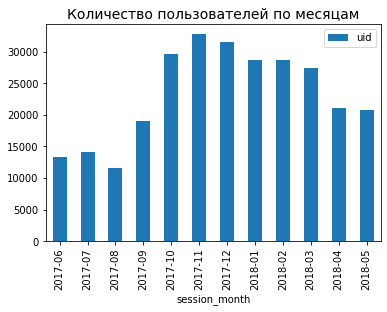

In [15]:
visits.groupby('session_month').agg({'uid': 'nunique'}).plot(kind = 'bar')
plt.title('Количество пользователей по месяцам', fontsize = 14)

Text(0.5, 1.0, 'Количество пользователей по месяцам и по источникам перехода на сайт')

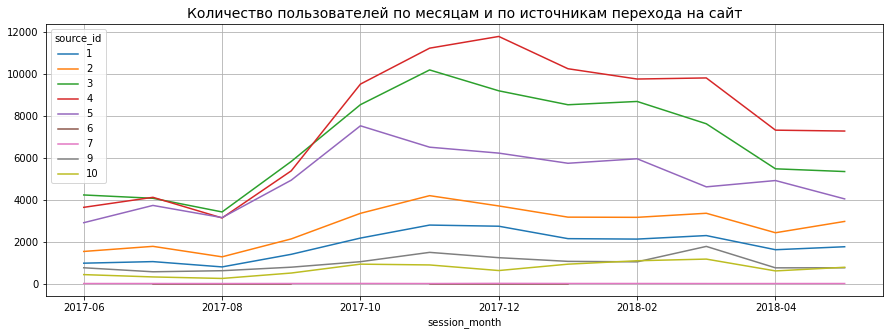

In [16]:
visits.pivot_table(index = 'session_month', columns = 'source_id', values = 'uid', 
                   aggfunc = 'nunique').plot(figsize = (15, 5), grid = True)
plt.title('Количество пользователей по месяцам и по источникам перехода на сайт', fontsize = 14)

Text(0.5, 1.0, 'Количество пользователей по месяцам и по девайсам')

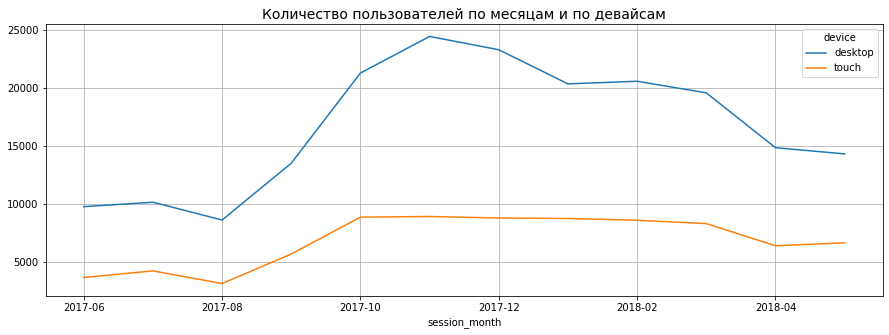

In [17]:
visits.pivot_table(index = 'session_month', columns = 'device', values = 'uid', 
                   aggfunc = 'nunique').plot(figsize = (15, 5), grid = True)
plt.title('Количество пользователей по месяцам и по девайсам', fontsize = 14)

Text(0.5, 1.0, 'Количество пользователей по неделям')

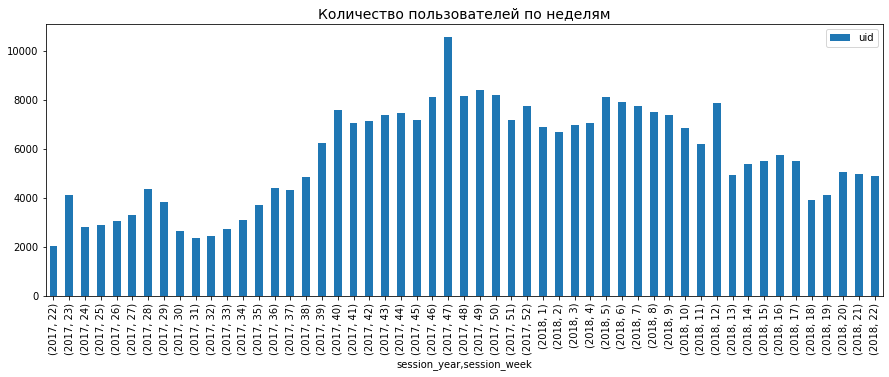

In [18]:
visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).plot(kind = 'bar', figsize = (15,5))
plt.title('Количество пользователей по неделям', fontsize = 14)

Text(0.5, 1.0, 'Количество пользователей по неделям и по источникам перехода на сайт')

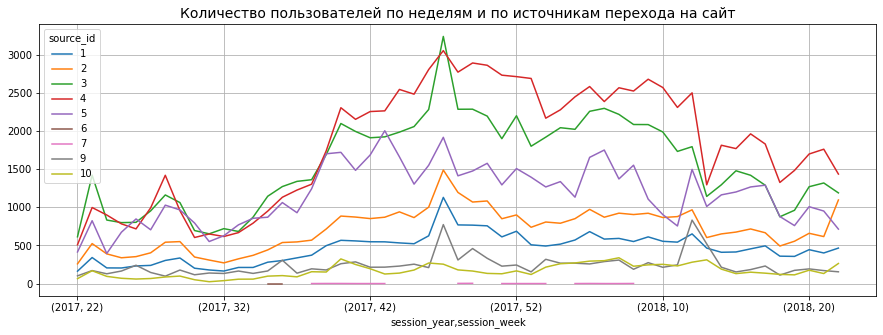

In [19]:
visits.pivot_table(index = ['session_year', 'session_week'], columns = 'source_id', values = 'uid', 
                   aggfunc = 'nunique').plot(figsize = (15, 5), grid = True)
plt.title('Количество пользователей по неделям и по источникам перехода на сайт', fontsize = 14)

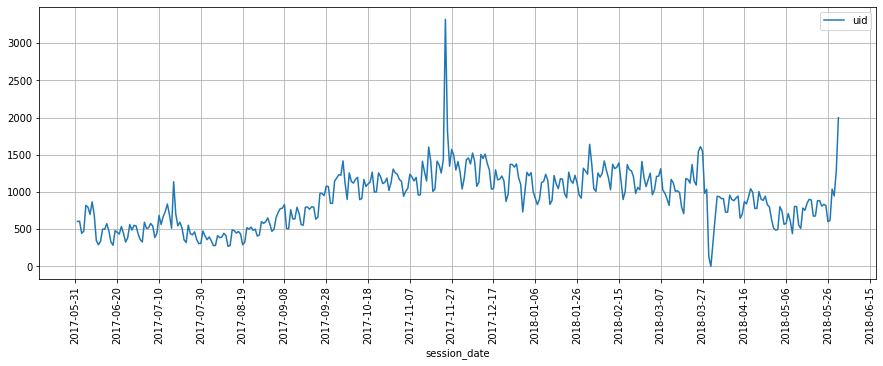

In [20]:
#количество пользователей по дням
ax = visits.groupby('session_date').agg({'uid': 'nunique'}).plot(figsize = (15,5),grid = True)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

In [21]:
print('Количество пользователей в среднем в день по каждому источнику')
visits.groupby(['source_id', 'session_date']).agg({'uid': 'nunique'}).reset_index().groupby('source_id')['uid'].mean().round().reset_index()

Количество пользователей в среднем в день по каждому источнику


,source_id,uid
0,1,81.0
1,2,121.0
2,3,233.0
3,4,275.0
4,5,176.0
5,6,1.0
6,7,1.0
7,9,36.0
8,10,26.0


In [22]:
#количество сессий в месяц на одного пользователя
sessions_per_user = visits.groupby(['session_month']).agg({'uid': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['n_sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user

,n_sessions,n_users,n_sessions_per_user
session_month,,,
2017-06,16505,13259,1.244815
2017-07,17828,14183,1.256998
2017-08,14355,11631,1.234202
2017-09,23907,18975,1.259921
2017-10,37903,29692,1.276539
2017-11,43969,32797,1.340641
2017-12,41983,31557,1.330386
2018-01,36939,28716,1.286356
2018-02,37182,28749,1.293332


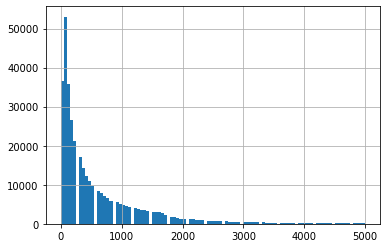

In [23]:
#длительность сессий
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration'].hist(bins = 100, range = (0, 5000))

In [24]:
#средняя длительность сессии (используем медиану, так как на среднюю повлияет большой разброс)
session_duration = (visits['session_duration'].median())/60
print('Длительность одной сессии в минутах:', session_duration)

Длительность одной сессии в минутах: 5.0


In [25]:
#найдем месяц первого посещения сайта для каждого пользователя
visits['session_month'] = pd.to_datetime(visits['session_month'])
first_session_month = visits.groupby(['uid'])['session_month'].min()
first_session_month.name = 'first_session_month'

In [26]:
visits = visits.join(first_session_month, on = 'uid')
visits.head()

,unnamed:_0,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_year,session_duration,first_session_month
0,0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,2017-12-01,2017,1080,2017-12-01
1,1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2018-02-01,2018,1680,2018-02-01
2,2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,2017-07-01,2017,0,2017-07-01
3,3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,2018-05-01,2018,1440,2018-03-01
4,4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,2017-12-01,2017,0,2017-12-01


In [27]:
#жизненный цикл каждой когорты пользователей (по месяцам)
visits['cohort_lifetime'] = visits['session_month'] - visits['first_session_month'] 
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

#количество пользователей по месяцам
visits_cohorts = visits.groupby(['first_session_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()

#начальное количество пользователей в каждой когорте
initial_users_count = visits_cohorts[visits_cohorts['cohort_lifetime'] == 0][['first_session_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_users'})

In [28]:
#расчет retention rate по когортам
visits_cohorts = visits_cohorts.merge(initial_users_count, on = 'first_session_month')
visits_cohorts['first_session_month'] = visits_cohorts['first_session_month'].dt.strftime('%Y-%m')
visits_cohorts['retention'] = visits_cohorts['uid'] / visits_cohorts['cohort_users']
retention_pivot = visits_cohorts.pivot_table(index = 'first_session_month', columns = 'cohort_lifetime', 
                                             values = 'retention', aggfunc = 'sum')

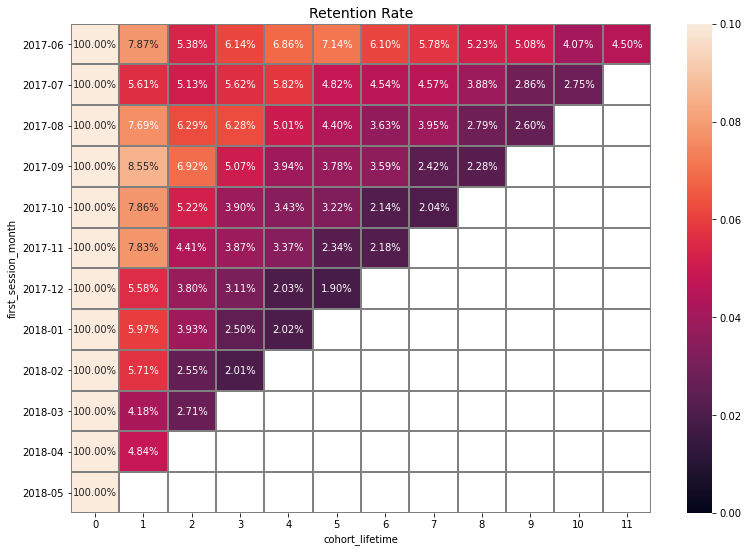

In [29]:
plt.figure(figsize = (13,9))
plt.title('Retention Rate', fontsize = 14)
sns.heatmap(retention_pivot, annot = True, fmt = '.2%', linewidths = 1, vmin=0, 
            vmax=0.1, linecolor = 'grey')

In [30]:
visits['source_id'].value_counts()

4     101794
3      85609
5      66905
2      47626
1      34121
9      13276
10     10025
7         36
6          6
Name: source_id, dtype: int64

Далее также будет рассчитан retention rate для каждого источника, из которого пришел пользователь. Было принято решение убрать строки с источниками 6 и 7, так как по этим источникам очень мало приходов на сайт по сравнению с остальными, поэтому нет смысла их учитывать. Также были отброшены когорты с декабря 2017 по май 2018 в связи с тем, что их жизненный цикл достаточно мал, но высокие проценты retention rate повлияют на retention rate когорт по источникам в течение жизненного цикла когорты.

In [31]:
#построение когорт по источникам, которые юзеры использовали для перехода на сайт
sources_cohorts = (visits[(visits['first_session_month'] < '2017-12-01') & (visits['source_id'] != 7) \
                          & (visits['source_id'] != 6)]
                   .groupby(['source_id', 'cohort_lifetime'])
                   .agg({'uid': 'nunique'})
                   .reset_index()
                  )
initial_users_count_sources = sources_cohorts[sources_cohorts['cohort_lifetime'] == 0][['source_id', 'uid']]
initial_users_count_sources = initial_users_count_sources.rename(columns={'uid': 'cohort_users'})
sources_cohorts = sources_cohorts.merge(initial_users_count_sources, on = 'source_id')
sources_cohorts['retention'] = sources_cohorts['uid'] / sources_cohorts['cohort_users']
retention_sources_pivot = sources_cohorts.pivot_table(index = 'source_id', columns = 'cohort_lifetime', 
                                             values = 'retention', aggfunc = 'sum')

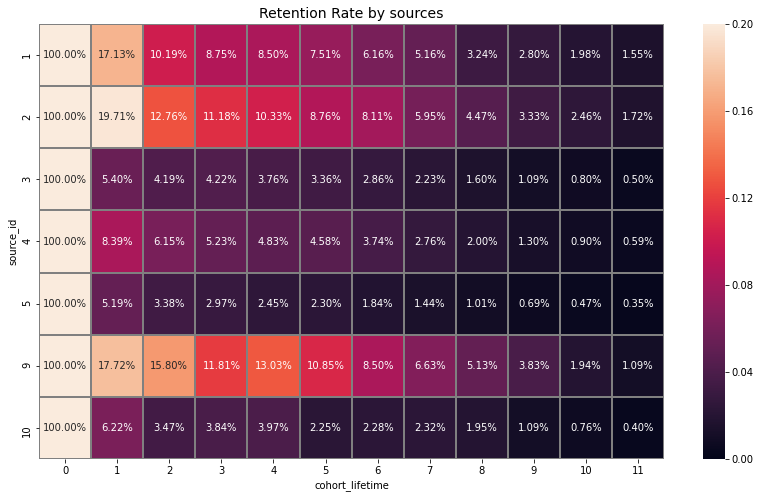

In [32]:
#тепловая карта для retention rate по источникам
plt.figure(figsize = (14,8))
plt.title('Retention Rate by sources',fontsize = 14)
sns.heatmap(retention_sources_pivot, annot = True, fmt = '.2%', linewidths = 1, vmin=0, vmax=0.2, 
            linecolor = 'grey')

### Вывод

В ходе анализа данных в таблице о посещениях сайта было выявлено среднее количество людей, которые заходят на сайт, в день (908), неделю (5825) и месяц (23228), а также среднее количество сессий в день (987). По графикам видно, что в ноябре сайт был самым посещаемым: если посмотреть на посещение по дням, то пик приходится на 24 ноября, возможно это было связано с акцией Black Friday, которая пришлась на этот день в 2017 году. Самым низким по посещеним был август, возможно низкая активность была связана с порой отпусков. 

Помимо этого были изучены разбивки посещений по источникам, из которых люди переходят на сайт. Самыми популярными источниками являются 4, 3 и 5, соответственно. Хотя в ранее описанный пик посещений (24 ноября) источник 3 даже опередил источник 4. 31 марта был всего лишь 1 переход на сайт, возможно были какие-то технические работы и сайт приостановил свою работу в тот день.

Гистограмма, показывающая распределение длительности посещений показала большое количество разных значений от 0 до 50000, поэтому для определения длительности одной сессии было принято решение использовать не среднюю, а медиану. Она показала, что длительность одной сессии составляет 5 минут.

Были выделены когорты по месяцам, их жизненные циклы и исследован retention rate (коэффициент удержания) для каждой когорты. В некоторых когортах видно, что люди не возвращались на сайт на следующий месяц после первого посещения. Однако, в целом можно сказать, что когорты июня и июля 2017 года самые "удачные", поскольку их retention rate на протяжении следующих месяцев либо растет, либо остается стабильно высоким (5% и выше).

Также был изучен retention rate для отдельных источников. В данном исследовании не учитывались 6 и 7 источники из-за очень маленького количества переходов пользователей по ним, а также когорты с декабря 2017 года из-за сравнительно малого жизненного цикла. Несмотря на то, что раннее было обнаружено, что лидерами по переходам являются 4, 3 и 5 источники, по удержанию пользователей их опередили 9, 2 и 1 источники. То есть пользователи, которые попали на сайт через эти источники, чаще возвращаются на сайт.

### Данные о продажах

In [33]:
orders.head()

,unnamed:_0,buy_ts,revenue,uid
0,0,2017-06-01 00:10:00,17.00,10329302124590727494
1,1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2,2017-06-01 00:27:00,0.37,17903680561304213844
3,3,2017-06-01 00:29:00,0.55,16109239769442553005
4,4,2017-06-01 07:58:00,0.37,14200605875248379450


In [34]:
#уберем строки с нулевыми покупками
orders = orders[orders['revenue'] != 0]

In [35]:
#таблица с временем первого визита и временем первой покупки пользователя
time_before_buy = visits.groupby('uid')['start_ts'].min().reset_index()
first_order = orders.groupby('uid')['buy_ts'].min().reset_index()
time_before_buy = pd.merge(time_before_buy, first_order, on = 'uid')

In [36]:
#проверка данных на корректность (покупка была совершена после начала сессии)
(time_before_buy[time_before_buy['buy_ts'] < time_before_buy['start_ts']]).shape[0]

0

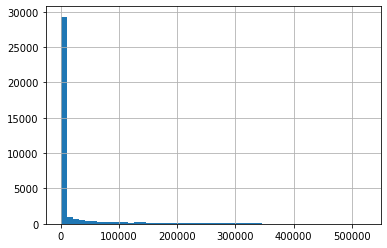

In [37]:
#время, через которое совершают первую покупку в минутах
time_before_buy['first_order_time'] = (time_before_buy['buy_ts'] - time_before_buy['start_ts']).dt.total_seconds()/60
time_before_buy['first_order_time'].hist(bins = 50)

In [38]:
print('Среднее время до первой покупки (в минутах):', round(time_before_buy['first_order_time'].median(), 2))

Среднее время до первой покупки (в минутах): 16.0


In [39]:
orders['buy_date'] = orders['buy_ts'].dt.date
#перевод даты покупки в месяц
orders['buy_month'] = orders['buy_date'].astype('datetime64[M]')

In [40]:
#месяц первой покупки каждого пользователя
first_buy_month = orders.groupby('uid')['buy_month'].min()
first_buy_month.name = 'first_buy_month'
orders = orders.join(first_buy_month, on = 'uid')
orders.head()

,unnamed:_0,buy_ts,revenue,uid,buy_date,buy_month,first_buy_month
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


In [41]:
#количество и сумма совершаемых покупок пользователями по месяцам
orders_cnt = orders.groupby('buy_month').agg({'uid': 'count', 'revenue': 'sum'}).reset_index()
orders_cnt

,buy_month,uid,revenue
0,2017-06-01,2353,9557.49
1,2017-07-01,2362,12539.47
2,2017-08-01,1803,8758.78
3,2017-09-01,3383,18345.51
4,2017-10-01,5677,27987.70
5,2017-11-01,5644,27069.93
6,2017-12-01,6206,36388.60
7,2018-01-01,4721,19417.13
8,2018-02-01,5280,25560.54
9,2018-03-01,5325,28834.59


In [42]:
#среднее количество покупок в месяц (не учитывался июнь 2018, потому что была 1 покупка)
print('Среднее количество покупок в месяц:', 
      round(orders_cnt[orders_cnt['buy_month'] != '2018-06-01']['uid'].mean(), 2))

Среднее количество покупок в месяц: 4196.92


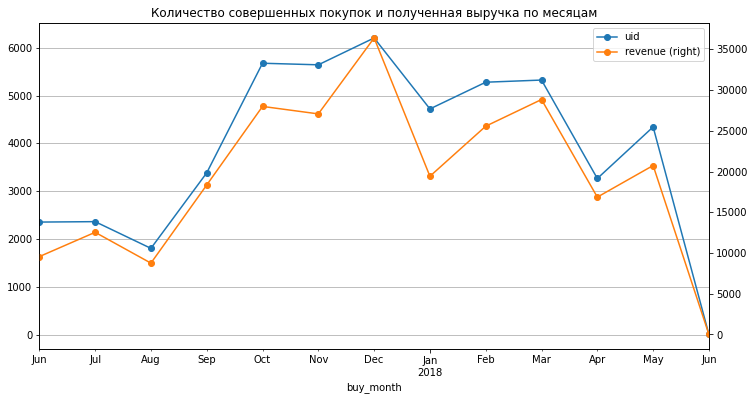

In [43]:
#график с двумя Y осями для количества покупок и полученной выручки по месяцам
fig, ax = plt.subplots(figsize = (12,6))
plt.title('Количество совершенных покупок и полученная выручка по месяцам')
orders_cnt.plot(x = 'buy_month', y = 'uid', marker = 'o', ax = ax) 
orders_cnt.plot(x = 'buy_month', y = 'revenue', marker = 'o', ax = ax, secondary_y=True) 
ax.yaxis.grid()

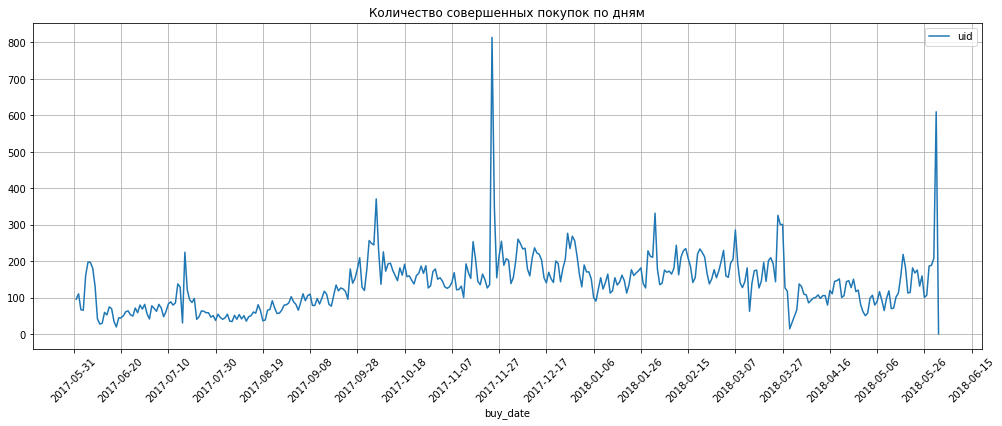

In [44]:
#график количества покупок по дням
ax = orders.groupby('buy_date').agg({'uid': 'count'}).plot(figsize = (17,6), grid = True)
plt.title('Количество совершенных покупок по дням')
plt.setp(ax.get_xticklabels(), rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

In [45]:
#выделение когорт, количества заказов и пользователей, полученной выручки по когортам
orders_by_cohorts = orders.groupby(['first_buy_month', 'buy_month']).agg({'revenue': 'sum', 
                                                                          'uid': 'count'}).reset_index()

orders_by_cohorts.columns = ['first_buy_month', 'buy_month', 'revenue', 'n_orders']

In [46]:
first_buy_month = first_buy_month.reset_index()
first_buy_month.columns = ['uid', 'first_buy_month']

In [47]:
#определение количества людей в когортах
cohort_sizes = first_buy_month.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_users']
cohort_sizes

,first_buy_month,n_users
0,2017-06-01,2022
1,2017-07-01,1922
2,2017-08-01,1369
3,2017-09-01,2579
4,2017-10-01,4340
5,2017-11-01,4078
6,2017-12-01,4380
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3534


In [48]:
#добавление данных о количестве людей, которые в первый раз совершили покупку каждый месяц
orders_by_cohorts = pd.merge(cohort_sizes, orders_by_cohorts, on='first_buy_month')
orders_by_cohorts['rev_per_order'] = (orders_by_cohorts['revenue'] / orders_by_cohorts['n_orders'])

In [49]:
orders_by_cohorts.head()

,first_buy_month,n_users,buy_month,revenue,n_orders,rev_per_order
0,2017-06-01,2022,2017-06-01,9557.49,2353,4.061832
1,2017-06-01,2022,2017-07-01,981.82,177,5.547006
2,2017-06-01,2022,2017-08-01,885.34,171,5.177427
3,2017-06-01,2022,2017-09-01,1931.30,224,8.621875
4,2017-06-01,2022,2017-10-01,2068.58,291,7.108522


In [50]:
print('Средний чек:', round(orders_by_cohorts['rev_per_order'].mean(), 2))

Средний чек: 7.66


In [51]:
#определение жизненного цикла когорты
orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['buy_month'] - orders_by_cohorts['first_buy_month'] 
orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['cohort_lifetime'] / np.timedelta64(1, 'M')
orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['cohort_lifetime'].round().astype('int')
orders_by_cohorts['first_buy_month'] = orders_by_cohorts['first_buy_month'].dt.strftime('%Y-%m')

In [52]:
#определение выручки, получаемой с одного пользователя
rev_per_order_cohorts = orders_by_cohorts.pivot_table(index = 'first_buy_month', columns = 'cohort_lifetime',
                                                        values = 'rev_per_order', aggfunc = 'mean')

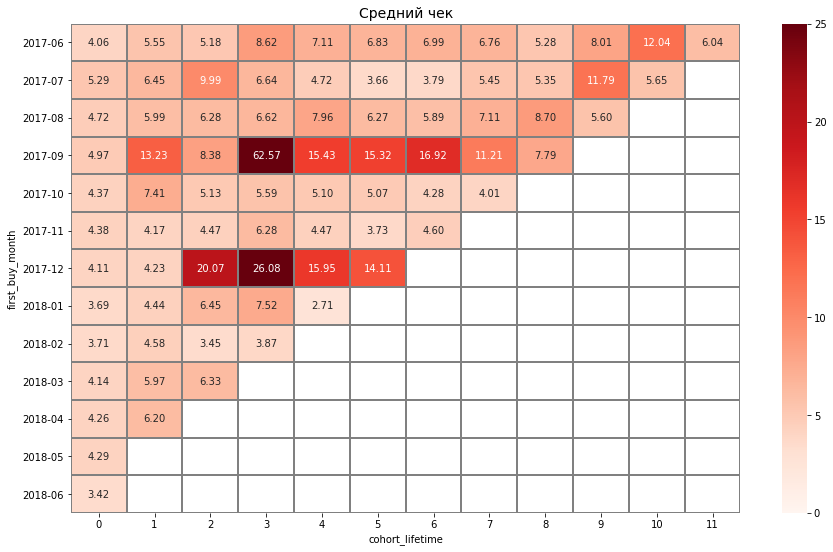

In [53]:
#средний чек по когортам по месяцам
plt.figure(figsize = (15,9))
plt.title('Средний чек', fontsize = 14)
sns.heatmap(rev_per_order_cohorts, annot = True, fmt = '.2f', linewidths = 1, cmap = 'Reds',
            vmin=0, vmax=25, linecolor = 'gray')

In [54]:
#определение ltv 
orders_by_cohorts['ltv'] = orders_by_cohorts['revenue'] / orders_by_cohorts['n_users']
orders_by_cohorts.head()

,first_buy_month,n_users,buy_month,revenue,n_orders,rev_per_order,cohort_lifetime,ltv
0,2017-06,2022,2017-06-01,9557.49,2353,4.061832,0,4.726751
1,2017-06,2022,2017-07-01,981.82,177,5.547006,1,0.485569
2,2017-06,2022,2017-08-01,885.34,171,5.177427,2,0.437854
3,2017-06,2022,2017-09-01,1931.30,224,8.621875,3,0.955143
4,2017-06,2022,2017-10-01,2068.58,291,7.108522,4,1.023037


In [55]:
#сводная таблица для ltv с накоплением
ltv = orders_by_cohorts.pivot_table(index='first_buy_month', columns='cohort_lifetime', 
                                       values='ltv', aggfunc='mean')
ltv.cumsum(axis=1).round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,4.73,5.21,5.65,6.61,7.63,8.36,9.31,9.9,10.45,11.06,11.63,11.88
2017-07,6.01,6.35,6.97,7.33,7.51,7.66,7.79,7.93,8.09,8.24,8.39,
2017-08,5.28,5.75,6.21,6.6,7.1,7.38,7.59,8,8.29,8.48,,
2017-09,5.65,6.77,7.29,11.27,11.67,12.31,13.02,13.26,13.44,,,
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11,5.16,5.56,5.76,6.08,6.23,6.28,6.4,,,,,
2017-12,4.74,5,5.93,6.99,7.31,7.65,,,,,,
2018-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02,4.16,4.44,4.51,4.59,,,,,,,,


In [56]:
month_5_cum_ltv = ltv.cumsum(axis=1).mean(axis=0)[4]
print('Средний LTV за 5 месяцев после первой покупки:', month_5_cum_ltv.round(2))

Средний LTV за 5 месяцев после первой покупки: 7.3


### Вывод

При изучении данных о продажах было выявлено, что в среднем люди совершают покупку после первого визита через 16 минут. Для расчета этого показателя также была использована медиана, так как на моду повлияло бы большое количество значений в районе 0 (возможно это были импульсивные покупки сразу после перехода на сайт), а на среднюю повлиял бы большой разброс значений (некоторые пользователи совершали первую покупку спустя пару лет после первого посещения).

Самое большое количество покупок (и по сумме выручки) было совершено в декабре. Возможно, это связано с зимними праздниками и люди осуществляли покупку подарков через сайт, хотя по дням пиком покупок (так же как и с посещениями) осталось 24 ноября.

В среднем в месяц на сайте соыершают 4197 покупок.

Средний чек сооставил 7,66 ден.ед. Если смортеть в разрезе когорт, то можно увидеть, что самый высокий средний чек у сентябрьской когорты в декабре и с января 2018 года средний чек у этой когорты держится на достаточно приемлемом уровне относительно других когорт. Похожая ситуация с декабрьской когортой, в которой достаточно высокий средний чек с февраля 2018 года.

Далее был рассчитан ltv по когортам с накоплением (так как в условиях не была задана маржинальность, то в данном исследовании использовалась revenue вместо gross profit). По нему видно, что со временем больше всего денег компании приносят июньская, сентябрьская и декабрьская когорты. 

Также был рассчитан средний ltv с накоплением за 5 месяцев, он составил 7,3 ден.ед. Такая граница была взята в связи с тем, что в дальнейшем исследовании roi видно, что на пятом месяце это значение примерно 0,7-0,8 у многих когорт. То есть проект еще не окупился, но он приближается к окупаемости. 

### Данные о затратах

In [57]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs['month'] = costs['month'].dt.strftime('%Y-%m')
costs.head()

,Unnamed: 0,source_id,dt,costs,month
0,0,1,2017-06-01,75.20,2017-06
1,1,1,2017-06-02,62.25,2017-06
2,2,1,2017-06-03,36.53,2017-06
3,3,1,2017-06-04,55.00,2017-06
4,4,1,2017-06-05,57.08,2017-06


In [58]:
print('Затраты на привлечение клиентов всего:', costs['costs'].sum())

Затраты на привлечение клиентов всего: 329131.62


Text(0.5, 1.0, 'Затраты по каждому источнику')

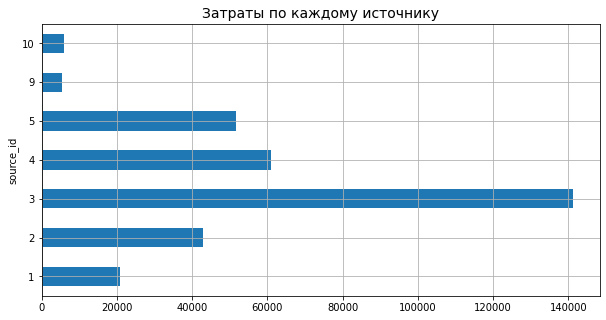

In [59]:
costs.groupby('source_id')['costs'].sum().plot(kind = 'barh', figsize = (10, 5), grid = True)
plt.title('Затраты по каждому источнику', fontsize = 14)

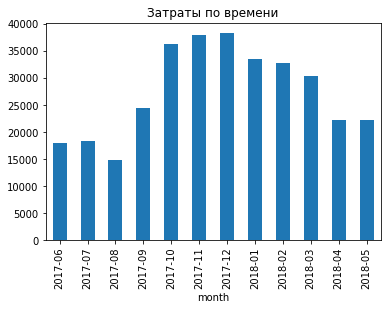

In [60]:
plt.title('Затраты по времени')
costs.groupby('month')['costs'].sum().plot(kind = 'bar')

In [61]:
#ежемесячные затраты на привлечение пользователей
monthly_costs = costs.groupby('month')['costs'].sum()
orders_by_cohorts = pd.merge(orders_by_cohorts, monthly_costs, left_on='first_buy_month', right_on='month')

#определение cтоимости привлечения одного пользователя (cac) и расчет окупаемости расходов (roi)
orders_by_cohorts['cac'] = orders_by_cohorts['costs'] / orders_by_cohorts['n_users']
orders_by_cohorts['roi'] = orders_by_cohorts['ltv'] / orders_by_cohorts['cac']

In [62]:
#сводная таблица для roi
roi = orders_by_cohorts.pivot_table(index = 'first_buy_month', columns = 'cohort_lifetime', 
                                    values = 'roi', aggfunc = 'mean')

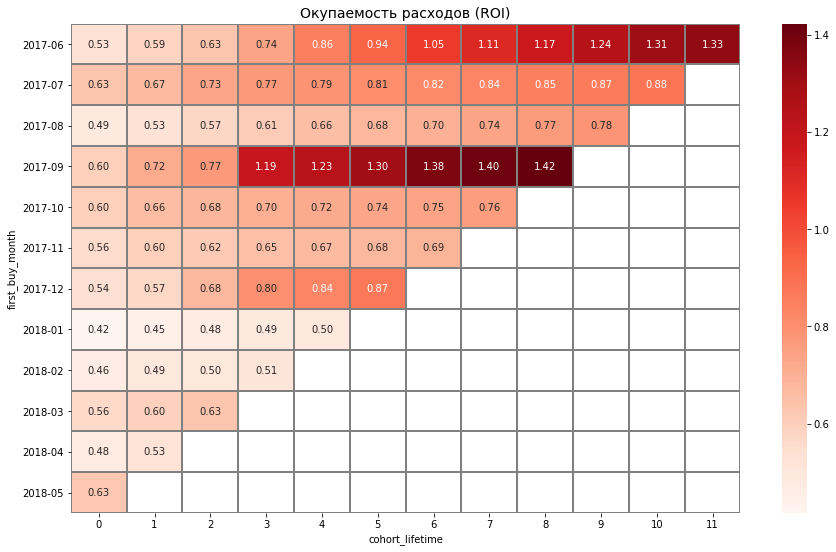

In [63]:
plt.figure(figsize = (15,9))
plt.title('Окупаемость расходов (ROI)', fontsize = 14)
sns.heatmap(roi.cumsum(axis=1), annot = True, fmt = '.2f', cmap="Reds", linewidths = 1, linecolor = 'grey')

In [64]:
print('Среднее ROI (с накоплением) по жизненному циклу когорт')
roi.cumsum(axis=1).mean(axis=0).reset_index().rename(columns = {0: 'accumulated ROI'})

Среднее ROI (с накоплением) по жизненному циклу когорт


,cohort_lifetime,accumulated ROI
0,0,0.540835
1,1,0.582000
2,2,0.631070
3,3,0.719738
4,4,0.782942
5,5,0.859870
6,6,0.896780
7,7,0.969905
8,8,1.053814
9,9,0.964461


In [65]:
#определяем с какого источника пользователь впервые попал на сайт
sources_users = (visits.groupby(['uid', 'first_session_month'])
                 .agg({'source_id': 'first', 'device': 'first'})
                 .reset_index()
                 .rename(columns = {'first_session_month': 'month'})
                )
sources_users['month'] = sources_users['month'].dt.strftime('%Y-%m')

In [66]:
#определяем количество пользователей и затрат по источникам в каждом месяце
sources_report = sources_users.groupby(['source_id', 'month']).agg({'uid': 'nunique'})
sources_costs = costs.groupby(['source_id', 'month']).agg({'costs': 'sum'})
sources_report = pd.merge(sources_report, sources_costs, on = ['source_id', 'month'])

#расчет затрат на привлечение пользователя
sources_report['cac'] = sources_report['costs'] / sources_report['uid']

sources_report.head()

uid    costs       cac
source_id month                           
1         2017-06   763  1125.61  1.475242
          2017-07   694  1072.88  1.545937
          2017-08   472   951.81  2.016547
          2017-09   859  1502.01  1.748556
          2017-10  1267  2315.75  1.827743

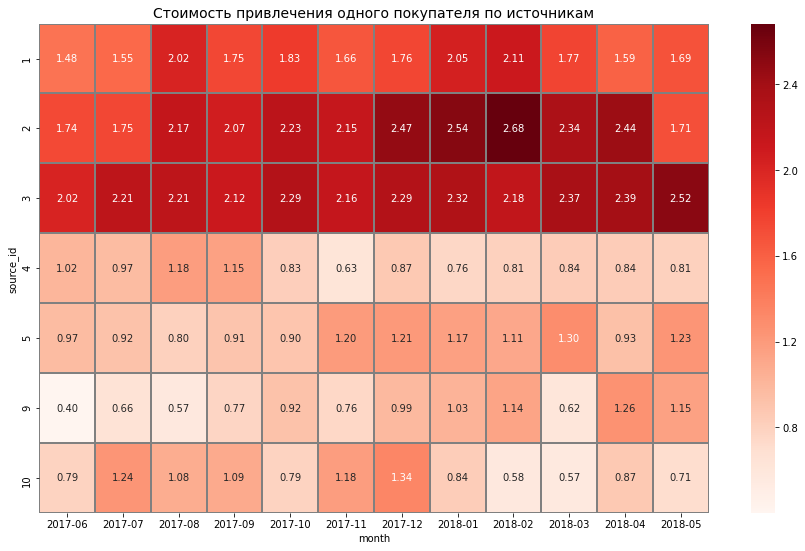

In [67]:
s_final_report = sources_report.pivot_table(index = 'source_id', columns = 'month', 
                                            values = 'cac', aggfunc = 'mean')
plt.figure(figsize = (15,9))
plt.title('Стоимость привлечения одного покупателя по источникам', fontsize = 14)
sns.heatmap(s_final_report, annot = True, fmt = '.2f', cmap = 'Reds', linewidths = 1, linecolor = 'grey')

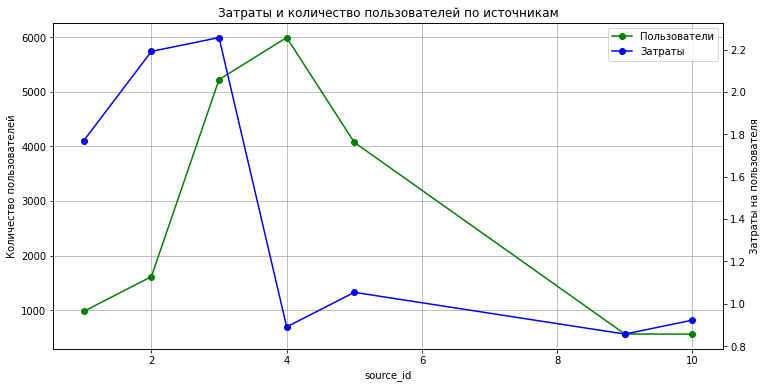

In [68]:
#график сравнения затрат на привлечение и количества пришедших на сайт пользователей в среднем по источникам
fig, ax = plt.subplots(figsize = (12,6))
plt.title('Затраты и количество пользователей по источникам')
line_1 = sources_report.groupby('source_id')['uid'].mean()
ax = line_1.plot(x = 'source_id', y = 'uid', marker = 'o', color = 'green', label = 'Пользователи') 
ax.set_ylabel('Количество пользователей')
line_2 = sources_report.groupby('source_id')['cac'].mean()
ax2 = ax.twinx()
ax2 = line_2.plot(x = 'source_id', y = 'cac', marker = 'o', color = 'blue', label = 'Затраты') 
ax2.set_ylabel('Затраты на пользователя')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.yaxis.grid()
ax.xaxis.grid()

In [69]:
#группировка пользователей по источникам и девайсам
sources_orders = (visits.groupby('uid')
                 .agg({'source_id': 'first', 'device': 'first'})
                 .reset_index()
                )
#определение выручки по пользователям
orders_uid = orders.groupby('uid')['revenue'].sum()

#объединение выручки и источников
sources_orders = pd.merge(sources_orders, orders_uid, on = 'uid')

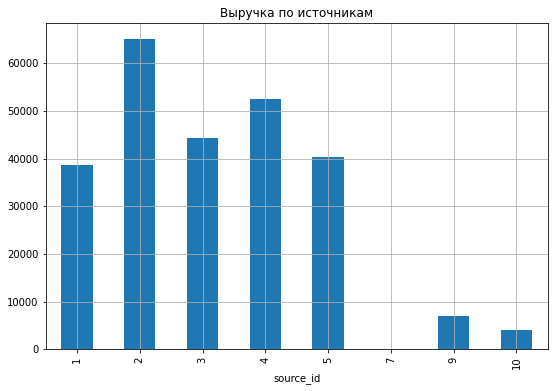

In [70]:
#график выручки, получаемой по источникам
plt.title('Выручка по источникам')
sources_orders.groupby('source_id')['revenue'].sum().plot(kind = 'bar', grid = True, figsize = (9, 6))

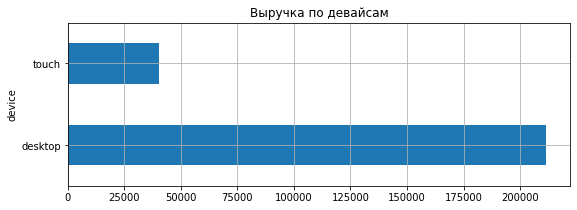

In [71]:
plt.title('Выручка по девайсам')
sources_orders.groupby('device')['revenue'].sum().plot(kind = 'barh', grid = True, figsize = (9, 3))

### Вывод

В ходе исследования затрат на привлечение посетителей было выявлено, что в сумме за весь исследуемый период на маркетинг было потрачено 329 131,62 ден.ед.

В разрезе источников привлечения пользователей самые большие затраты за весь период приходятся на источник 3, они составляют больше 42% от всех затрат на маркетинг. По времени маркетологи самые большие затраты заложили на октябрь, ноябрь и декабрь (то есть подготавливали людей к Black Friday и предновогодним покупкам).

ROI по жизненному циклу с накоплением показал, что в среднем когорта окупается к 8 месяцу. Однако, по тепловой карте видно, что 2 когорты окупились на 4 и на 7 месяцы. В целом, уже на 5 месяце ROI по всем когортам в районе 0,7-0,8, а в среднем равен 0,85 на этой стадии. Для такого проекта, как сервис по поиску мероприятий, это достаточно хорошо, и именно 5ый месяц был использован для раннее посчитанного ltv. 

Также были посчитаны затраты на привлечение одного покупателя из каждого источника. Из тепловой карты видно, что самыми "дорогими" являются пользователи, пришедшие из 3, 2 и 1 источников. Но так как большее количество людей приходит из 4, 3 и 5, то видно что в ноябре маркетологи решили увеличить затраты на привлечение пользователей из источника 5.

### 3. Общий вывод и рекомендации

Исследуя посещения сайта, продажи и затраты, были выявлены самые перспективные источники, из которых пользователи переходят на сайт: 4, 3 и 5. Также 2 источник приносит самую большую выручку. 

Затраты на 3 источник можно сократить, поскольку они составляют большую часть всех затрат, однако пользователи из этого источника приносят меньше выручки, чем пользователи из 2 и 4 источников. Хотя из 3 источника и приходит большое количество пользователей, в целом retention rate показал, что возвращаются они реже, чем пользователи из других источников. Соответственно такие колоссальные затраты на этот источник не совсем оправданы. Источники 2 и 4 при увеличении вложений в них могут принести большее количество лояльных пользователей и большую сумму выручки. Изученные показатели и построенные графики говорят о том, что маркетологам стоит увеличить затраты на эти источники.  С еще большим приходом пользователей из этих источников увеличится и конверсия покупок, которые они совершают.

Из платформ самой лучшей является desktop. Эта платформа приносит и больше пользователей, и больше выручки, поэтому руководству компании стоит продолжать соверошенствовать десктопную версию сайта для своих основных пользователей.

В среднем пользователи по когортам окупаются к 8 месяцу, однако исследование ROI показало, что июньская и сентябрьская когорты окупились в декабре, а январская когорта достаточно скудно начала свой жизненный цикл. При этом затраты на маркетинг в январе достаточно высокие. Возможно, для этого месяца стоит немного сократить затраты и увеличить затраты на привлечение клиентов в июне, которые точно окупятся к концу года.